### <center>k-NN</center>
1. k-NN (sales **prediction**)

2. k-NN (music **recommendation**)

In [2]:
# Preparation

# Import packages
import pandas as pd
import sklearn.model_selection as sk_ms
import sklearn.metrics as sk_m
import sklearn.neighbors as sk_n
import matplotlib.pyplot as plt
import seaborn as sns
# load the data
df_customers = pd.read_csv('B2B sales.csv')
# split into training and testing set
df_train, df_test = sk_ms.train_test_split(df_customers, train_size = 0.7,
                                          random_state = 123, shuffle = True)

100%|██████████| 36/36 [00:01<00:00, 23.32it/s]


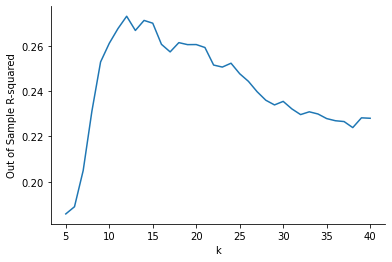

In [8]:
# k-NN (Sales Prediction)
# By going through the values of k from 5 to 40

score_list = []

import tqdm
for k in tqdm.tqdm(range(5, 41)):
    # Fit a k-NN model on the training set
    knn = sk_n.KNeighborsRegressor(n_neighbors=k)
    #nothing in the parenteces if without specific parameter
    knn.fit(df_train.loc[:, df_train.columns != 'ltv'], df_train.ltv)

    # Make predictions on the test set
    preds = knn.predict(df_test.loc[:, df_test.columns != 'ltv'])

    # Find the R-squared on the test set and append it to the
    # score list
    score_list.append(sk_m.r2_score(df_test.ltv, preds))

# Plot the results
import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(range(5, 41), score_list)
plt.xlabel('k')
plt.ylabel('Out of Sample R-squared')
sns.despine()

In [ ]:
# preparation

import pandas as pd
import string
import numpy as np

raw_data = pd.read_csv('canvas_survey.csv')

In [ ]:
# k-NN (Music Recommendation)
# will update later